## Iris数据集上用2维特征、2类分类可视化
决策边界
ROC曲线
PR曲线

In [1]:
import pandas as pd
import numpy as np

# 使用accuracy_score作为分类回归模型性能的评价
from sklearn.metrics import accuracy_score 

import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [2]:
#读取数据
# csv文件没有列名，增加列名
# 花萼长度、宽度；花瓣长度、宽度
feat_names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']

dpath = "./data/"
df = pd.read_csv(dpath + "iris.csv", names = feat_names, header=None)

#通过观察前5行，了解数据每列（特征）的概况
df.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
#类别
unique_Class = df['Class'].unique()
unique_Class

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [4]:
#只考虑两类分类：setosa vs. non_setosa
target_map = {'Iris-setosa':0, #山鸢尾
              'Iris-versicolor':1, #变色鸢尾
              'Iris-virginica':1 }  #2，弗吉尼亚鸢尾

# Use the pandas apply method to numerically encode our attrition target variable
df['Class'] = df['Class'].apply(lambda x: target_map[x])
#df.head()

#或者pandas自动定义标签转换
#df['Class'] = pd.Categorical(df['Class']).codes

In [5]:
df.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


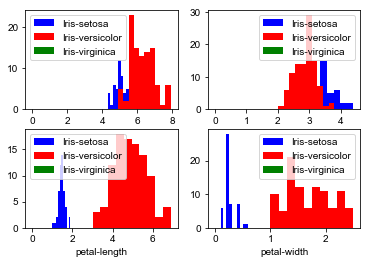

In [6]:
#查看不同类别下特征的直方图，初步了解特征的可分性
#3个类别的颜色
colors = ['blue', 'red', 'green']

# plot histogram
for feature in range(df.shape[1] - 1): # (shape = 150, 5), 5-4 = 4，每维特征
    plt.subplot(2, 2, feature+1)  # subplot starts from 1 (not 0)
    for label, color in zip(range(len(unique_Class)), colors): #每个类别
        feat_name = df.columns[feature]
        samples = df[df['Class']==label][feat_name]  #该类别的所有样本
        plt.hist(samples,
                 label = unique_Class[label],
                 color=color)
    
    plt.xlabel(df.columns[feature])
    plt.legend()
plt.show()

花瓣的长度和宽度比较能区分不同类别的鸢尾

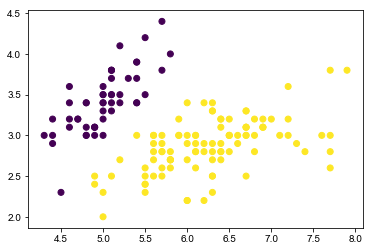

In [7]:
#花萼长度和宽度的散点图
plt.scatter(df['sepal-length'], df['sepal-width'], c=df['Class']);
plt.show()

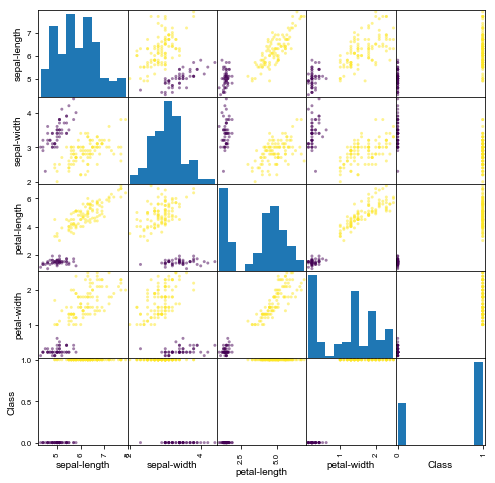

In [8]:
#每2维特征的散点图
pd.plotting.scatter_matrix(df, c=df['Class'], figsize=(8, 8));
plt.show()

In [9]:
# 从原始数据中分离输入特征x和输出y
y = df['Class']
#X = df.drop(['petal-length', 'petal-width', 'Class'], axis = 1)
#X = df[['sepal-length','sepal-length']]
X = df.iloc[:, 0:2]  # 只取前两维特征

In [10]:
# 特征缩放:数据标准化
from sklearn.preprocessing import StandardScaler

#模型训练
scaler = StandardScaler()
scaler.fit(X)

#特征缩放
X = scaler.transform(X)

In [11]:
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
X_train.shape

(120, 2)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#设置超参数搜索范围
Cs = [ 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(C = Cs)

#生成学习器实例
lr = LogisticRegression()

#生成GridSearchCV实例
grid= GridSearchCV(lr, tuned_parameters,cv=10, scoring='neg_log_loss',n_jobs = 4)

#训练，交叉验证对超参数调优
grid.fit(X_train, y_train)

lr_best = grid.best_estimator_

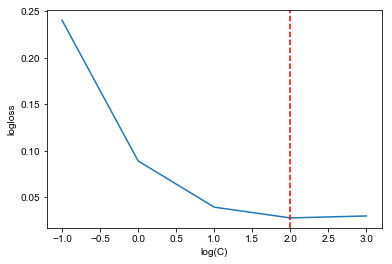

In [13]:
test_means = - grid.cv_results_[ 'mean_test_score' ]

n_Cs = len(Cs)

plt.plot(np.log10(Cs), test_means)

#最佳超参数
best_C = grid.best_params_['C']
plt.axvline(np.log10(best_C), color='r', ls='--')


plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'logloss' )

plt.show()

In [14]:
lr_best.coef_

array([[10.9896484, -5.5699963]])

In [15]:
lr_best.intercept_

array([7.01742638])

In [16]:
#画分类边界
h = .02  # step size in the mesh

N, M = 500, 500  # 横纵各采样多少个值
x1_min, x2_min = X.min(axis=0) -1
x1_max, x2_max = X.max(axis=0) +1

t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)

x1, x2 = np.meshgrid(t1, t2)  # 生成网格采样点

X_test = np.stack((x1.flat, x2.flat), axis=1)  # 测试点
y_test = lr_best.predict(X_test)
#y_test = lr_best.predict_proba(X_test)  #heatmap?

y_test = y_test.reshape(x1.shape)

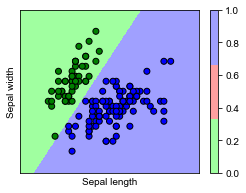

In [17]:
cm_light = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])

plt.figure(figsize=(4, 3))
plt.pcolormesh(x1, x2, y_test, cmap=plt.cm.Paired)
plt.pcolormesh(x1, x2, y_test, cmap=cm_light)
plt.colorbar()
# Plot also the training points

plt.scatter(X[:, 0], X[:, 1], c = y, cmap=cm_dark,marker='o',edgecolors='k')

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [18]:
#画出分类器的决策边界
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None):
    if eps is None:
        eps = X.std() / 2.
    
    x1_min, x2_min = X.min(axis=0) - eps
    x1_max, x2_max = X.max(axis=0) + eps
   
    x1 = np.linspace(x1_min, x1_max, 500)
    x2 = np.linspace(x2_min, x2_max, 500)

    # 生成网格采样点
    X1, X2 = np.meshgrid(x1, x2)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, colors=['blue', 'red'])
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black")
    
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    
    my_x1_ticks = np.linspace(x1_min, x1_max, 10)
    my_x2_ticks = np.linspace(x2_min, x2_max, 10)
    
    ax.set_xticks(my_x1_ticks)
    ax.set_yticks(my_x2_ticks)

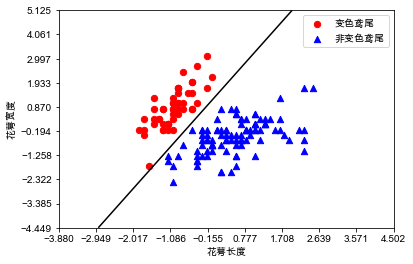

In [19]:
plt.scatter(X[y == 0, 0], X[y == 0, 1],
        c='red', marker='o' , s=40, label= u'变色鸢尾')

plt.scatter(X[y == 1, 0], X[y == 1, 1],
        c='blue', marker='^', s=40, label= u'非变色鸢尾')

#plt.scatter(X[:, 0], X[:, 1], c = y, cmap=cm_dark,marker='o',edgecolors='k')

plot_2d_separator(lr_best, X_test) # plot the boundary
#plt.xlabel(df.columns[feature])
#plt.ylabel(df.columns[feature])

plt.xlabel(u'花萼长度')
plt.ylabel(u'花萼宽度')

    
plt.legend()
plt.show()

## ROC曲线

In [20]:
from sklearn.metrics import roc_curve, auc

In [21]:
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    
    #plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    
    plt.legend(loc='lower right',fontsize = 16)
    
    plt.plot([0,1],[0,1],'r--')
    
    plt.ylabel('TPR', fontsize = 16)
    plt.xlabel('FPR', fontsize = 16)

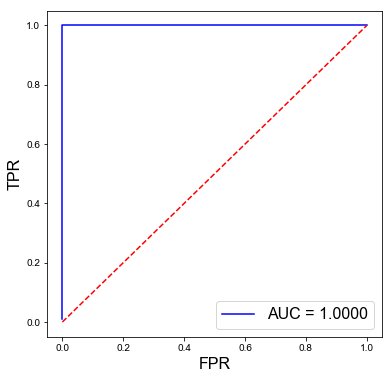

In [22]:
scores = lr_best.decision_function(X)

plt.figure(figsize=(6,6))
plot_roc(y, scores) 

In [23]:
#绘制PR曲线
def plot_PR(labels, predict_prob):
    precision,recall,thresholds = precision_recall_curve(labels,predict_prob)
    
    average_precision = average_precision_score(labels, predict_prob)
    
    #plt.title('ROC')
    plt.plot(recall, precision,'b',label='AP = %0.4f'% average_precision)
    
    plt.legend(loc='lower right',fontsize = 16)
    
    plt.plot([0,1],[0,1],'r--')
    
    plt.ylabel(u'精度', fontsize = 16)
    plt.xlabel(u'召回率', fontsize = 16)    

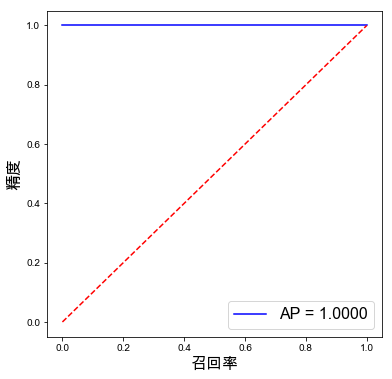

In [24]:
#scores = lr_best.decision_function(X)
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(6,6))
plot_PR(y, scores) 